In [17]:
# package import

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
# import pandas as pd
# import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
%matplotlib inline
plt.style.use('bmh')

import time


In [66]:
import numpy as np
print(np.__version__)


1.21.6


# Metrics
Model 1: 17 total epochs (7 for best result), train time -> 154.31 seconds, test time -> 0.48 seconds, test acc -> 94.61%
Model 2: 26 total epochs (16 for best result), train time -> 790.56 seconds, test time -> 1.28 seconds, test acc -> 95.18%

In [2]:
# Load in the data
trainDataFull = np.load('kmnist-train-imgs.npz')
trainLabelFull = np.load('kmnist-train-labels.npz')
testData = np.load('kmnist-test-imgs.npz')
testLabel = np.load('kmnist-test-labels.npz')

X_trainFull = trainDataFull['arr_0']
t_trainFull = trainLabelFull['arr_0']
X_test = testData['arr_0']
t_test = testLabel['arr_0']

assert X_trainFull.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert t_trainFull.shape == (60000,)
assert t_test.shape == (10000,)
# 10 classes of characters


In [19]:
# Train-Val split and scaling
X_train, X_val, t_train, t_val = train_test_split(
    X_trainFull, t_trainFull, test_size=0.15, random_state=24
)

X_train = X_train.reshape(X_train.shape[0], 28 * 28)
X_test = X_test.reshape(X_test.shape[0], 28 * 28)
X_val = X_val.reshape(X_val.shape[0], 28 * 28)

# scaling
scaler = MinMaxScaler(copy=False)

scaler.fit(X_train)
scaler.fit(X_val)
scaler.fit(X_test)


X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)

print(X_train.shape)

(51000, 28, 28, 1)


# First vary the loss function:
Test categorical cross entropy and MSE

In [20]:
# Base Model
# Build a CNN model
# Play with the different parameters to get a decent enough model that doesn't melt your computer
tf.keras.backend.clear_session()
modelbase = models.Sequential()

# Convolutional layers
modelbase.add(layers.Conv2D(32, (7,7), activation='relu', input_shape=(28, 28, 1), padding="same"))
modelbase.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
modelbase.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
modelbase.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))

# Dense layers for classification
modelbase.add(layers.Flatten())
modelbase.add(layers.Dense(128, activation='relu'))
modelbase.add(layers.Dense(64, activation='relu'))
modelbase.add(layers.Dense(10, activation='softmax')) # 10 different classes, so final layers has 10 outputs

modelbase.summary()
print(modelbase)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        1600      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               12845184  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [21]:
# Sparse Categorical Cross Entropy
# Compile and train the model
modelbase.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            #   loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=True), # Use focal cross entropy if classes imbalanced
              metrics=['accuracy'])

t0 = time.time()

history = modelbase.fit(X_train, t_train, epochs=30, 
                    validation_data=(X_val, t_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=10,
                    restore_best_weights=True))

t1 = time.time()

modelTime = t1 - t0

print('Base Model with SCCE time to train was ', modelTime, ' seconds.')

test_loss, test_acc = modelbase.evaluate(X_test,  t_test, verbose=2)



Epoch 1/30
1594/1594 [==============================] - 29s 17ms/step - loss: 0.3384 - accuracy: 0.9261 - val_loss: 0.1380 - val_accuracy: 0.9608
Epoch 2/30
1594/1594 [==============================] - 26s 16ms/step - loss: 0.0906 - accuracy: 0.9723 - val_loss: 0.1121 - val_accuracy: 0.9687
Epoch 3/30
1594/1594 [==============================] - 26s 16ms/step - loss: 0.0723 - accuracy: 0.9782 - val_loss: 0.0935 - val_accuracy: 0.9712
Epoch 4/30
1594/1594 [==============================] - 26s 16ms/step - loss: 0.0568 - accuracy: 0.9838 - val_loss: 0.1477 - val_accuracy: 0.9658
Epoch 5/30
1594/1594 [==============================] - 26s 16ms/step - loss: 0.0516 - accuracy: 0.9849 - val_loss: 0.1012 - val_accuracy: 0.9723
Epoch 6/30
1594/1594 [==============================] - 26s 16ms/step - loss: 0.0412 - accuracy: 0.9877 - val_loss: 0.1453 - val_accuracy: 0.9712
Epoch 7/30
1594/1594 [==============================] - 26s 16ms/step - loss: 0.0415 - accuracy: 0.9884 - val_loss: 0.1648 -

In [23]:
# MSE
# Compile and train the model
tf.keras.backend.clear_session()
modelbase.compile(optimizer='nadam',
              loss=tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size'),
            #   loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=True), # Use focal cross entropy if classes imbalanced
              metrics=['accuracy'])

t0 = time.time()

history = modelbase.fit(X_train, t_train, epochs=30, 
                    validation_data=(X_val, t_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=10,
                    restore_best_weights=True))

t1 = time.time()

modelTime = t1 - t0

print('Base Model with MSE time to train was ', modelTime, ' seconds.')

test_loss, test_acc = modelbase.evaluate(X_test,  t_test, verbose=2)

Epoch 1/30
1594/1594 [==============================] - 28s 17ms/step - loss: 27.6053 - accuracy: 0.0972 - val_loss: 27.6368 - val_accuracy: 0.0854
Epoch 2/30
1594/1594 [==============================] - 26s 16ms/step - loss: 27.6053 - accuracy: 0.0954 - val_loss: 27.6368 - val_accuracy: 0.0957
Epoch 3/30
1594/1594 [==============================] - 26s 16ms/step - loss: 27.6054 - accuracy: 0.0949 - val_loss: 27.6368 - val_accuracy: 0.0887
Epoch 4/30
1594/1594 [==============================] - 26s 16ms/step - loss: 27.6054 - accuracy: 0.0983 - val_loss: 27.6368 - val_accuracy: 0.0969
Epoch 5/30
1594/1594 [==============================] - 26s 16ms/step - loss: 27.6053 - accuracy: 0.0989 - val_loss: 27.6368 - val_accuracy: 0.0894
Epoch 6/30
1594/1594 [==============================] - 26s 16ms/step - loss: 27.6054 - accuracy: 0.0992 - val_loss: 27.6368 - val_accuracy: 0.0940
Epoch 7/30
1594/1594 [==============================] - 26s 16ms/step - loss: 27.6053 - accuracy: 0.0979 - val_l

# Modify Batch Normalization and MaxPooling
Have results before from neither batch normalization nor max pooling. Run same architecture with batch only, pool only, and both batch and pool
Then test efficacy of dropout

In [27]:
# Batch only
# Compile and train the model
tf.keras.backend.clear_session()
modelbatch = models.Sequential()

# Convolutional layers
modelbatch.add(layers.Conv2D(32, (7,7), activation='relu', input_shape=(28, 28, 1), padding="same"))
modelbatch.add(layers.BatchNormalization())
modelbatch.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
modelbatch.add(layers.BatchNormalization())
modelbatch.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
modelbatch.add(layers.BatchNormalization())
modelbatch.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))

modelbatch.add(layers.Flatten())
modelbatch.add(layers.Dense(128, activation='relu'))
modelbatch.add(layers.Dense(64, activation='relu'))
modelbatch.add(layers.Dense(10, activation='softmax')) # 10 different classes, so final layers has 10 outputs


modelbatch.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            #   loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=True), # Use focal cross entropy if classes imbalanced
              metrics=['accuracy'])

t0 = time.time()

history = modelbatch.fit(X_train, t_train, epochs=30, 
                    validation_data=(X_val, t_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=10,
                    restore_best_weights=True))

t1 = time.time()

modelTime = t1 - t0

print('Batch Model time to train was ', modelTime, ' seconds.')

test_loss, test_acc = modelbatch.evaluate(X_test,  t_test, verbose=2)


Epoch 1/30
1594/1594 [==============================] - 51s 31ms/step - loss: 0.4869 - accuracy: 0.9106 - val_loss: 0.2066 - val_accuracy: 0.9476
Epoch 2/30
1594/1594 [==============================] - 50s 31ms/step - loss: 0.1088 - accuracy: 0.9680 - val_loss: 0.1144 - val_accuracy: 0.9682
Epoch 3/30
1594/1594 [==============================] - 49s 30ms/step - loss: 0.0770 - accuracy: 0.9768 - val_loss: 0.1186 - val_accuracy: 0.9712
Epoch 4/30
1594/1594 [==============================] - 49s 31ms/step - loss: 0.0613 - accuracy: 0.9820 - val_loss: 0.1346 - val_accuracy: 0.9706
Epoch 5/30
1594/1594 [==============================] - 49s 31ms/step - loss: 0.0451 - accuracy: 0.9866 - val_loss: 0.1508 - val_accuracy: 0.9662
Epoch 6/30
1594/1594 [==============================] - 49s 31ms/step - loss: 0.0393 - accuracy: 0.9894 - val_loss: 0.1219 - val_accuracy: 0.9740
Epoch 7/30
1594/1594 [==============================] - 49s 31ms/step - loss: 0.0309 - accuracy: 0.9907 - val_loss: 0.1517 -

In [28]:
# Batch and Pool
# Compile and train the model
tf.keras.backend.clear_session()
modelpool = models.Sequential()

# Convolutional layers
modelpool.add(layers.Conv2D(32, (7,7), activation='relu', input_shape=(28, 28, 1), padding="same"))
modelpool.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
modelpool.add(layers.MaxPooling2D((2, 2)))
modelpool.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
modelpool.add(layers.MaxPooling2D((2, 2)))
modelpool.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))

modelpool.add(layers.Flatten())
modelpool.add(layers.Dense(128, activation='relu'))
modelpool.add(layers.Dense(64, activation='relu'))
modelpool.add(layers.Dense(10, activation='softmax')) # 10 different classes, so final layers has 10 outputs


modelpool.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            #   loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=True), # Use focal cross entropy if classes imbalanced
              metrics=['accuracy'])

t0 = time.time()

history = modelpool.fit(X_train, t_train, epochs=30, 
                    validation_data=(X_val, t_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=10,
                    restore_best_weights=True))

t1 = time.time()

modelTime = t1 - t0

print('Batch Model time to train was ', modelTime, ' seconds.')

test_loss, test_acc = modelpool.evaluate(X_test,  t_test, verbose=2)

Epoch 1/30
1594/1594 [==============================] - 13s 7ms/step - loss: 0.2878 - accuracy: 0.9384 - val_loss: 0.0935 - val_accuracy: 0.9719
Epoch 2/30
1594/1594 [==============================] - 11s 7ms/step - loss: 0.0822 - accuracy: 0.9760 - val_loss: 0.0679 - val_accuracy: 0.9816
Epoch 3/30
1594/1594 [==============================] - 12s 7ms/step - loss: 0.0746 - accuracy: 0.9783 - val_loss: 0.0732 - val_accuracy: 0.9798
Epoch 4/30
1594/1594 [==============================] - 11s 7ms/step - loss: 0.0603 - accuracy: 0.9820 - val_loss: 0.0905 - val_accuracy: 0.9793
Epoch 5/30
1594/1594 [==============================] - 11s 7ms/step - loss: 0.0561 - accuracy: 0.9841 - val_loss: 0.0933 - val_accuracy: 0.9758
Epoch 6/30
1594/1594 [==============================] - 10s 7ms/step - loss: 0.0483 - accuracy: 0.9859 - val_loss: 0.0797 - val_accuracy: 0.9786
Epoch 7/30
1594/1594 [==============================] - 11s 7ms/step - loss: 0.0453 - accuracy: 0.9875 - val_loss: 0.0820 - val_ac

In [29]:
# Pool and Batch
# Compile and train the model
tf.keras.backend.clear_session()
modelboth = models.Sequential()

# Convolutional layers
modelboth.add(layers.Conv2D(32, (7,7), activation='relu', input_shape=(28, 28, 1), padding="same"))
modelboth.add(layers.BatchNormalization())
modelboth.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
modelboth.add(layers.MaxPooling2D((2, 2)))
modelboth.add(layers.BatchNormalization())
modelboth.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
modelboth.add(layers.MaxPooling2D((2, 2)))
modelboth.add(layers.BatchNormalization())
modelboth.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))

modelboth.add(layers.Flatten())
modelboth.add(layers.Dense(128, activation='relu'))
modelboth.add(layers.Dense(64, activation='relu'))
modelboth.add(layers.Dense(10, activation='softmax')) # 10 different classes, so final layers has 10 outputs


modelboth.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            #   loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=True), # Use focal cross entropy if classes imbalanced
              metrics=['accuracy'])

t0 = time.time()

history = modelboth.fit(X_train, t_train, epochs=30, 
                    validation_data=(X_val, t_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=10,
                    restore_best_weights=True))

t1 = time.time()

modelTime = t1 - t0

print('Batch Model time to train was ', modelTime, ' seconds.')

test_loss, test_acc = modelboth.evaluate(X_test,  t_test, verbose=2)

Epoch 1/30
1594/1594 [==============================] - 14s 8ms/step - loss: 0.1910 - accuracy: 0.9429 - val_loss: 0.0997 - val_accuracy: 0.9698
Epoch 2/30
1594/1594 [==============================] - 12s 8ms/step - loss: 0.0660 - accuracy: 0.9801 - val_loss: 0.0835 - val_accuracy: 0.9774
Epoch 3/30
1594/1594 [==============================] - 12s 8ms/step - loss: 0.0468 - accuracy: 0.9863 - val_loss: 0.0809 - val_accuracy: 0.9774
Epoch 4/30
1594/1594 [==============================] - 12s 7ms/step - loss: 0.0353 - accuracy: 0.9898 - val_loss: 0.0727 - val_accuracy: 0.9823
Epoch 5/30
1594/1594 [==============================] - 11s 7ms/step - loss: 0.0264 - accuracy: 0.9920 - val_loss: 0.0892 - val_accuracy: 0.9802
Epoch 6/30
1594/1594 [==============================] - 11s 7ms/step - loss: 0.0228 - accuracy: 0.9937 - val_loss: 0.0599 - val_accuracy: 0.9848
Epoch 7/30
1594/1594 [==============================] - 12s 7ms/step - loss: 0.0222 - accuracy: 0.9935 - val_loss: 0.0590 - val_ac

In [30]:
# Now try Batch+Pool with dropout
# Pool and Batch
# Compile and train the model
tf.keras.backend.clear_session()
modeldrop = models.Sequential()

# Convolutional layers
modeldrop.add(layers.Conv2D(32, (7,7), activation='relu', input_shape=(28, 28, 1), padding="same"))
modeldrop.add(layers.BatchNormalization())
modeldrop.add(layers.Dropout(0.5))
modeldrop.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
modeldrop.add(layers.MaxPooling2D((2, 2)))
modeldrop.add(layers.BatchNormalization())
modeldrop.add(layers.Dropout(0.5))
modeldrop.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
modeldrop.add(layers.MaxPooling2D((2, 2)))
modeldrop.add(layers.BatchNormalization())
modeldrop.add(layers.Dropout(0.5))
modeldrop.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))

modeldrop.add(layers.Flatten())
modeldrop.add(layers.Dense(128, activation='relu'))
modeldrop.add(layers.Dense(64, activation='relu'))
modeldrop.add(layers.Dense(10, activation='softmax')) # 10 different classes, so final layers has 10 outputs


modeldrop.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            #   loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=True), # Use focal cross entropy if classes imbalanced
              metrics=['accuracy'])

t0 = time.time()

history = modeldrop.fit(X_train, t_train, epochs=30, 
                    validation_data=(X_val, t_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=10,
                    restore_best_weights=True))

t1 = time.time()

modelTime = t1 - t0

print('Batch Model time to train was ', modelTime, ' seconds.')

test_loss, test_acc = modeldrop.evaluate(X_test,  t_test, verbose=2)

Epoch 1/30
1594/1594 [==============================] - 15s 9ms/step - loss: 0.3091 - accuracy: 0.9059 - val_loss: 0.1443 - val_accuracy: 0.9573
Epoch 2/30
1594/1594 [==============================] - 13s 8ms/step - loss: 0.1047 - accuracy: 0.9683 - val_loss: 0.0945 - val_accuracy: 0.9730
Epoch 3/30
1594/1594 [==============================] - 13s 8ms/step - loss: 0.0775 - accuracy: 0.9765 - val_loss: 0.0875 - val_accuracy: 0.9784
Epoch 4/30
1594/1594 [==============================] - 13s 8ms/step - loss: 0.0609 - accuracy: 0.9816 - val_loss: 0.0979 - val_accuracy: 0.9743
Epoch 5/30
1594/1594 [==============================] - 13s 8ms/step - loss: 0.0545 - accuracy: 0.9836 - val_loss: 0.0706 - val_accuracy: 0.9824
Epoch 6/30
1594/1594 [==============================] - 13s 8ms/step - loss: 0.0456 - accuracy: 0.9864 - val_loss: 0.0633 - val_accuracy: 0.9830
Epoch 7/30
1594/1594 [==============================] - 13s 8ms/step - loss: 0.0379 - accuracy: 0.9886 - val_loss: 0.0618 - val_ac

In [4]:
# Build a CNN model
# Play with the different parameters to get a decent enough model that doesn't melt your computer
tf.keras.backend.clear_session()
model1 = models.Sequential()

# Convolutional layers
model1.add(layers.Conv2D(32, (7,7), activation='relu', input_shape=(28, 28, 1), padding="same"))
model1.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
model1.add(layers.MaxPooling2D((2, 2)))

# Dense layers for classification
model1.add(layers.Flatten())
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(10, activation='softmax')) # 10 different classes, so final layers has 10 outputs

In [5]:
model1.summary()
print(model1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        1600      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

In [6]:
# Compile and train the model
model1.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            #   loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=True), # Use focal cross entropy if classes imbalanced
              metrics=['accuracy'])

t0 = time.time()

history = model1.fit(X_train, t_train, epochs=30, 
                    validation_data=(X_val, t_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=10,
                    restore_best_weights=True))

t1 = time.time()

model1Time = t1 - t0

print('Model 1 time to train was ', model1Time, ' seconds.')


Epoch 1/30
1594/1594 [==============================] - 15s 6ms/step - loss: 0.2714 - accuracy: 0.9306 - val_loss: 0.1165 - val_accuracy: 0.9668
Epoch 2/30
1594/1594 [==============================] - 8s 5ms/step - loss: 0.0818 - accuracy: 0.9756 - val_loss: 0.1155 - val_accuracy: 0.9660
Epoch 3/30
1594/1594 [==============================] - 8s 5ms/step - loss: 0.0645 - accuracy: 0.9803 - val_loss: 0.0968 - val_accuracy: 0.9748
Epoch 4/30
1594/1594 [==============================] - 8s 5ms/step - loss: 0.0581 - accuracy: 0.9828 - val_loss: 0.0847 - val_accuracy: 0.9794
Epoch 5/30
1594/1594 [==============================] - 10s 6ms/step - loss: 0.0517 - accuracy: 0.9846 - val_loss: 0.1105 - val_accuracy: 0.9752
Epoch 6/30
1594/1594 [==============================] - 10s 6ms/step - loss: 0.0375 - accuracy: 0.9892 - val_loss: 0.0841 - val_accuracy: 0.9806
Epoch 7/30
1594/1594 [==============================] - 9s 6ms/step - loss: 0.0458 - accuracy: 0.9873 - val_loss: 0.0705 - val_accura

KeyError: 'epochs'

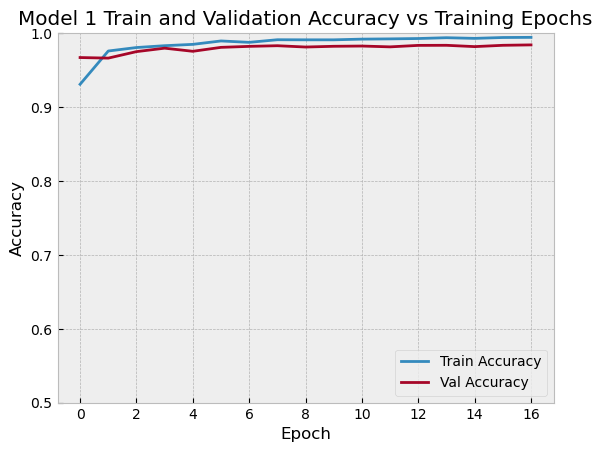

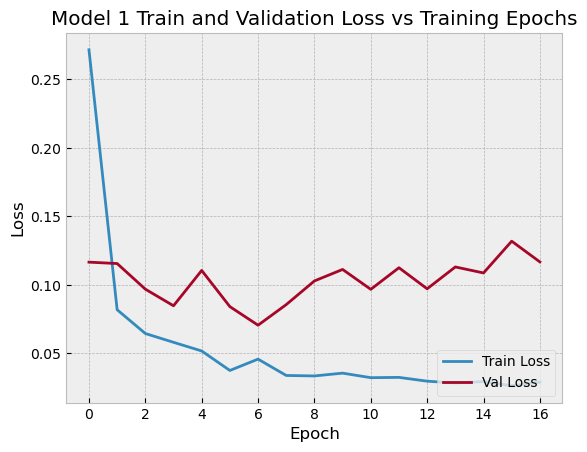

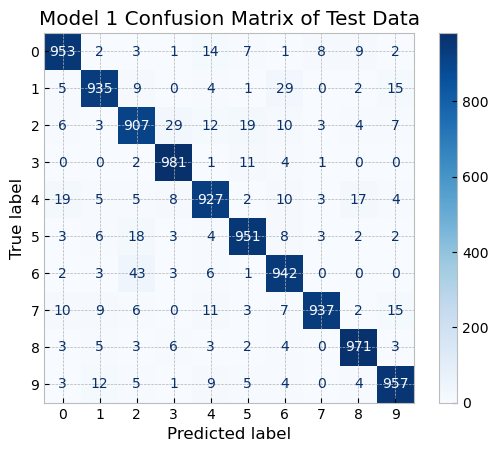

313/313 - 0s - loss: 0.2459 - accuracy: 0.9461
Model 1 Test classification time is  0.5347607135772705  seconds.


In [9]:
# Evaluation
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Model 1 Train and Validation Accuracy vs Training Epochs')

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.title('Model 1 Train and Validation Loss vs Training Epochs')



# Get predictions
t0 = time.time()

predTest = model1.predict(X_test)
predClasses = np.argmax(predTest, axis=1)

t1 = time.time()
model1Time_test = t1 - t0

# Confusion matrix
cm = confusion_matrix(t_test, predClasses)

labelNums = np.arange(10)
# Confusion matrix display
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labelNums)

# Plot the test confusion matrix
display.plot(cmap='Blues')
plt.title('Model 1 Confusion Matrix of Test Data')
plt.show()

test_loss, test_acc = model1.evaluate(X_test,  t_test, verbose=2)

print('Model 1 Test classification time is ', model1Time_test, ' seconds.')

In [14]:
# Let's try a deeper model, using BatchNormalization to allow for the deeper architecture

tf.keras.backend.clear_session()
model2 = models.Sequential()

# Convolutional layers
model2.add(layers.Conv2D(32, (7,7), activation='relu', input_shape=(28, 28, 1), padding="same"))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.5))
model2.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.5))
model2.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.5))
model2.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))
model2.add(layers.MaxPooling2D((2, 2)))


# model1.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
# model1.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
# model1.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))

# Dense layers for classification
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(10, activation='softmax')) # 49 different classes, so final layers has 10 outputs

model2.summary()
print(model1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        1600      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       7

In [15]:
# Compile and train the model
model2.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              # loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=True), # Use focal cross entropy if classes imbalanced
              metrics=['accuracy'])

t0 = time.time()

history = model2.fit(X_train, t_train, epochs=30, 
                    validation_data=(X_val, t_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=10,
                    restore_best_weights=True))

t1 = time.time()

model2Time = t1 - t0

print('Model 2 time to train was ', model2Time, ' seconds.')

Epoch 1/30
1594/1594 [==============================] - 32s 19ms/step - loss: 0.6659 - accuracy: 0.8510 - val_loss: 0.1865 - val_accuracy: 0.9478
Epoch 2/30
1594/1594 [==============================] - 30s 19ms/step - loss: 0.1482 - accuracy: 0.9558 - val_loss: 0.1131 - val_accuracy: 0.9668
Epoch 3/30
1594/1594 [==============================] - 30s 19ms/step - loss: 0.1014 - accuracy: 0.9700 - val_loss: 0.0926 - val_accuracy: 0.9734
Epoch 4/30
1594/1594 [==============================] - 30s 19ms/step - loss: 0.0798 - accuracy: 0.9757 - val_loss: 0.0924 - val_accuracy: 0.9771
Epoch 5/30
1594/1594 [==============================] - 30s 19ms/step - loss: 0.0645 - accuracy: 0.9810 - val_loss: 0.0781 - val_accuracy: 0.9797
Epoch 6/30
1594/1594 [==============================] - 30s 19ms/step - loss: 0.0542 - accuracy: 0.9841 - val_loss: 0.0812 - val_accuracy: 0.9783
Epoch 7/30
1594/1594 [==============================] - 30s 19ms/step - loss: 0.0445 - accuracy: 0.9866 - val_loss: 0.0753 -

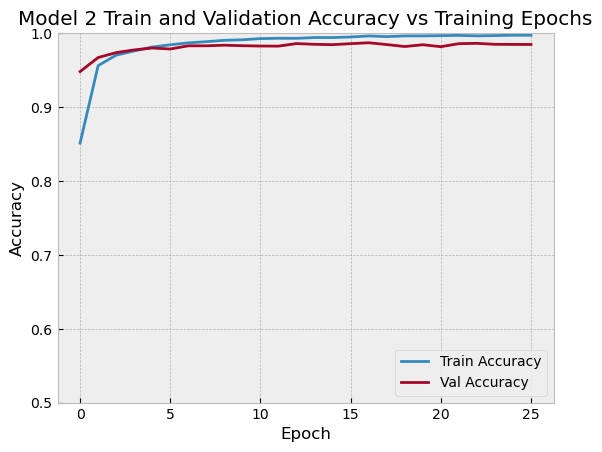

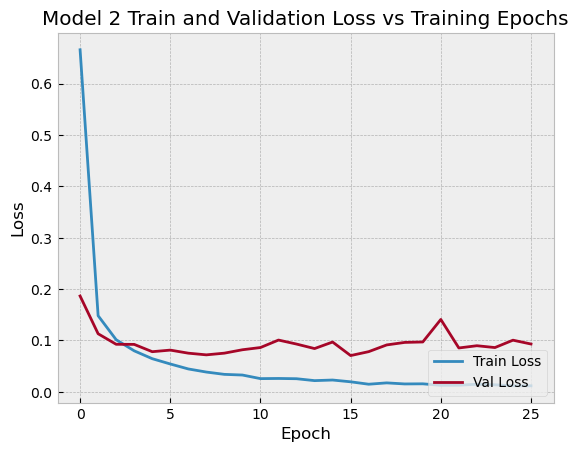

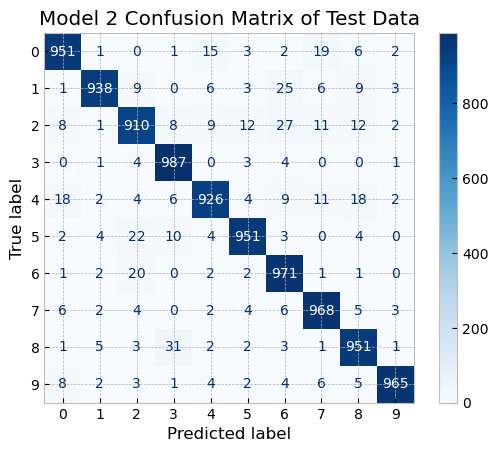

313/313 - 1s - loss: 0.2558 - accuracy: 0.9518
Model 2 Test classification time is  1.2762770652770996  seconds.


In [16]:
# Evaluation
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Model 2 Train and Validation Accuracy vs Training Epochs')

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.title('Model 2 Train and Validation Loss vs Training Epochs')



# Get predictions
t0 = time.time()

predTest = model2.predict(X_test)
predClasses = np.argmax(predTest, axis=1)

t1 = time.time()
model2Time_test = t1 - t0

# Confusion matrix
cm = confusion_matrix(t_test, predClasses)

labelNums = np.arange(10)
# Confusion matrix display
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labelNums)

# Plot the test confusion matrix
display.plot(cmap='Blues')
plt.title('Model 2 Confusion Matrix of Test Data')
plt.show()

test_loss, test_acc = model2.evaluate(X_test,  t_test, verbose=2)

print('Model 2 Test classification time is ', model2Time_test, ' seconds.')

In [ ]:
# Very shallow model